# Fun or Fact?

Jupyter notebook per l'analisi e la visualizzazione dei dati raccolti dalle pagine Instagram di [The Gap](https://www.instagram.com/thegap_media/) e [Factanza](https://www.instagram.com/factanza/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data_thegap = pd.read_csv('TheGap_db.csv', header=0, sep=',', encoding='utf-8')
data_factanza = pd.read_csv('factanza_db.csv', header=0, sep=',', encoding='utf-8')

data_thegap.head()

,Data,Tipo,Likes,Commenti,Condivisioni,Tema,Reazioni
0,2025-01-01,img,23000,363,317,FunFact_Italia,Negativa
1,2025-01-02,img,18300,347,425,Fact_Italia,Negativa
2,2025-01-02,img,19100,81,357,FunFact_Estero,Positiva
3,2025-01-03,img,14300,275,113,Fact_Italia,Negativa
4,2025-01-03,img,22600,358,307,FunFact_Italia,Positiva


In [10]:
data_factanza.head()

,Data,Tipo,Likes,Commenti,Condivisioni,Tema,Reazioni
0,2025-01-01,carosello,2041,3,18,Fact_Italia,Negativa
1,2025-01-01,video,3381,6,35,FunFact,Positiva
2,2025-01-01,carosello,7447,32,221,FunFact,Positiva
3,2025-01-02,carosello,8387,12,333,FunFact,Positiva
4,2025-02-02,video,3321,170,43,FunFact_Estero,Negativa


## Attività e frequenza di pubblicazione

### Post pubblicati al giorno

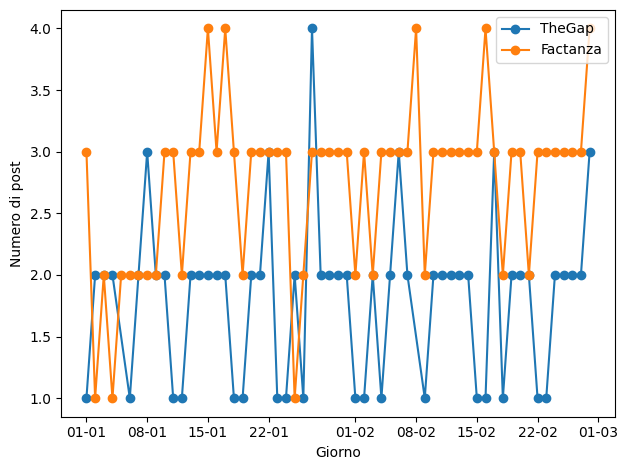

In [3]:
from matplotlib.dates import DateFormatter

data_thegap['Data'] = pd.to_datetime(data_thegap['Data'])
data_factanza['Data'] = pd.to_datetime(data_factanza['Data'])

for df, label in [(data_thegap, "TheGap"), (data_factanza, "Factanza")]:
    df_mes = df.groupby(df['Data'].dt.to_period('d')).size().sort_index()
    plt.plot(df_mes.index.to_timestamp(), df_mes.values, marker='o', label=label)

plt.legend(loc='upper right')
plt.xlabel("Giorno")
plt.ylabel("Numero di post")
plt.gca().xaxis.set_major_formatter(DateFormatter('%d-%m'))
plt.tight_layout()
plt.show()


### Post pubblicati per giorno della settimana

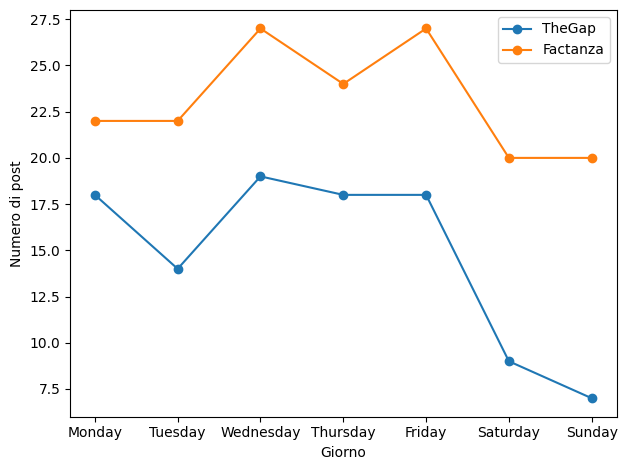

In [4]:
for df,label in [(data_thegap, "TheGap"), (data_factanza, "Factanza")]:
    df['Data'] = pd.to_datetime(df['Data'], format='%m/%d/%Y')
    dow = df['Data'].dt.day_name().value_counts().reindex(
            ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
    plt.plot(dow.index, dow.values, marker='o', label=label)

plt.xlabel("Giorno")
plt.ylabel("Numero di post")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

### Distribuzione del formato dei post

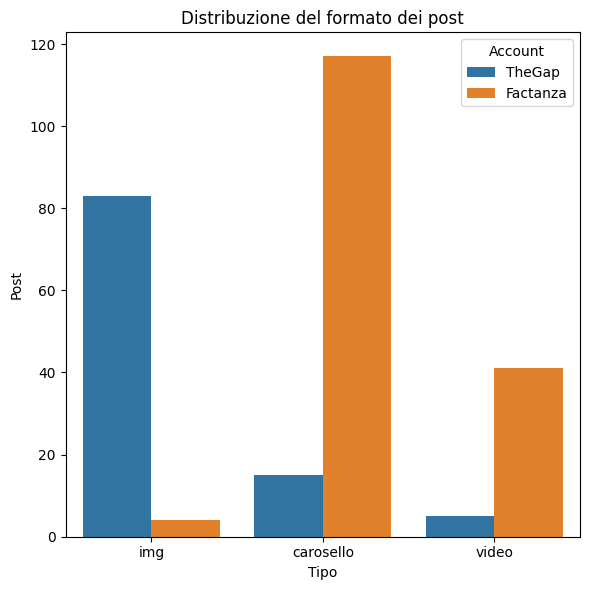

In [5]:
import seaborn as sns

df_long = pd.concat([
    data_thegap.assign(Account='TheGap'),
    data_factanza.assign(Account='Factanza')
])

plt.figure(figsize=(6, 6))
sns.countplot(data=df_long, x='Tipo', hue='Account')
plt.title("Distribuzione del formato dei post")
plt.ylabel("Post")
plt.tight_layout()
plt.show()

### Distribuzione dei Temi

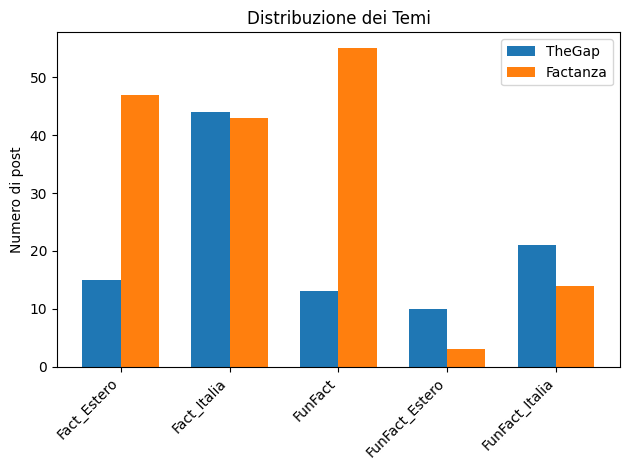

In [6]:
cnt1 = data_thegap['Tema'].value_counts().sort_index()
cnt2 = data_factanza['Tema'].value_counts().sort_index()
ind  = np.arange(len(cnt1))

width = 0.35
plt.bar(ind - width/2, cnt1.values, width, label='TheGap')
plt.bar(ind + width/2, cnt2.values, width, label='Factanza')
plt.xticks(ind, cnt1.index, rotation=45, ha='right')
plt.ylabel("Numero di post")
plt.title("Distribuzione dei Temi")
plt.legend()
plt.tight_layout()
plt.show()

### Engagement medio per Tema

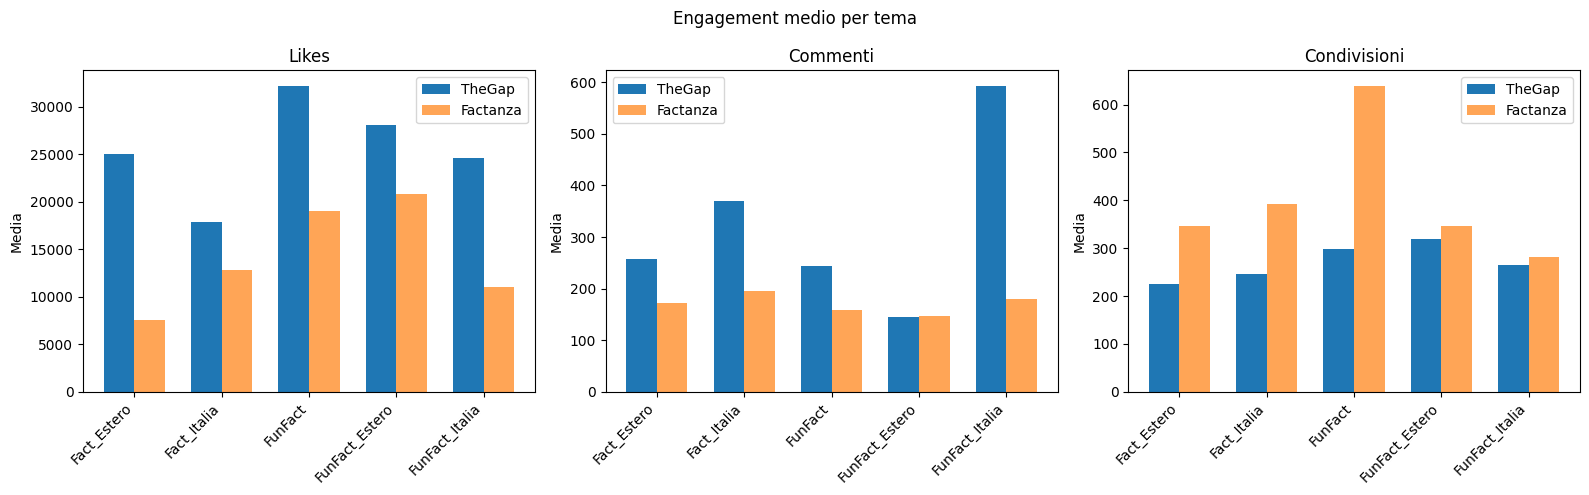

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True)
metrics = ['Likes', 'Commenti', 'Condivisioni']

for i, metric in enumerate(metrics):
    mean1 = data_thegap.groupby('Tema')[metric].mean().reindex(cnt1.index)
    mean2 = data_factanza.groupby('Tema')[metric].mean().reindex(cnt2.index)
    axes[i].bar(ind - width/2, mean1, width, label='TheGap')
    axes[i].bar(ind + width/2, mean2, width, label='Factanza', alpha=0.7)
    axes[i].set_title(metric)
    axes[i].set_xticks(ind)
    axes[i].set_xticklabels(cnt1.index, rotation=45, ha='right')
    axes[i].set_ylabel("Media")
    axes[i].legend()

plt.suptitle("Engagement medio per tema")
plt.tight_layout()
plt.show()


### Reazioni per tema

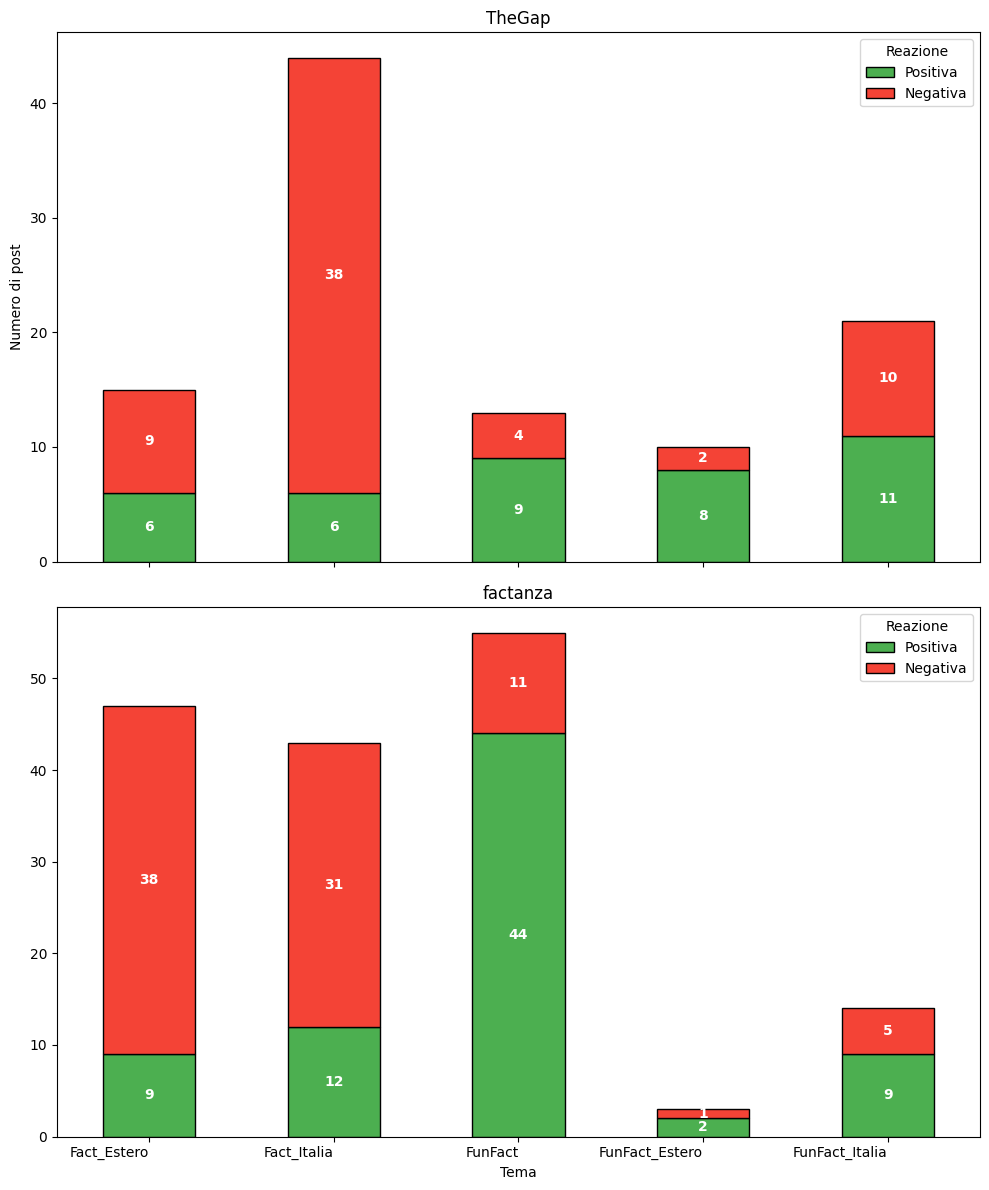

In [8]:
import seaborn as sns

all_temi = pd.Index(data_thegap['Tema'].unique()).union(data_factanza['Tema'].unique()).sort_values()

agg1 = data_thegap.groupby(['Tema','Reazioni']).size().unstack(fill_value=0).reindex(all_temi, fill_value=0)
agg2 = data_factanza.groupby(['Tema','Reazioni']).size().unstack(fill_value=0).reindex(all_temi, fill_value=0)

fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

colors = ['#4CAF50', '#F44336'] 

agg1[['Positiva','Negativa']].plot(
    kind='bar', stacked=True, ax=axes[0], color=colors, edgecolor='black')
axes[0].set_title("TheGap")
axes[0].set_ylabel("Numero di post")
axes[0].legend(title="Reazione")

agg2[['Positiva','Negativa']].plot(
    kind='bar', stacked=True, ax=axes[1], color=colors, edgecolor='black')
axes[1].set_title("factanza")
axes[1].legend(title="Reazione")

for ax, agg in zip(axes, [agg1, agg2]):
    for idx, tema in enumerate(all_temi):
        y_pos = 0
        for reazione, color in zip(['Positiva', 'Negativa'], colors):
            val = agg.at[tema, reazione] if reazione in agg.columns else 0
            if val > 0:
                ax.text(idx, y_pos + val/2, str(val), ha='center', va='center', color='white', fontsize=10, fontweight='bold')
                y_pos += val

plt.xticks(rotation=0, ha='right')
plt.xlabel("Tema")
plt.tight_layout()
plt.show()